In [1]:
# Baseline for using MLP on rest + working memory (together and separately)

import pickle
import numpy as np

with open('../F1F4_ids_rest_nback.bin', 'rb') as f:
    F1F4_ids_rest_nback = pickle.load(f)
    
for key in F1F4_ids_rest_nback:
    print(key)
    
F1_train_ids = F1F4_ids_rest_nback['F1_train_ids']
F4_train_ids = F1F4_ids_rest_nback['F4_train_ids']
F1_test_ids = F1F4_ids_rest_nback['F1_test_ids']
F4_test_ids = F1F4_ids_rest_nback['F4_test_ids']

print(F1_train_ids[0])

F1_train_ids
F1_test_ids
F4_train_ids
F4_test_ids
[4 4]


In [2]:
# Load F1,F4 train and test, resting state and nback

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

F1_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_test_ids]

F1_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_test_ids]

print(len(F1_train_rest))
print(len(F4_train_rest))
print(len(F1_test_rest))
print(len(F4_test_rest))

print(len(F1_train_nback))
print(len(F4_train_nback))
print(len(F1_test_nback))
print(len(F4_test_nback))

74
93
24
30
74
93
24
30


In [4]:
# Normalize all datasets

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])

normalizeSubjects(F1_train_rest)
normalizeSubjects(F4_train_rest)
normalizeSubjects(F1_test_rest)
normalizeSubjects(F4_test_rest)

normalizeSubjects(F1_train_nback)
normalizeSubjects(F4_train_nback)
normalizeSubjects(F1_test_nback)
normalizeSubjects(F4_test_nback)

print('Normalization complete')

Normalization complete


In [5]:
# Labels

y_F1F4_train_rest = np.hstack([np.zeros([len(F1_train_rest)]), np.ones([len(F4_train_rest)])])
y_F1F4_test_rest = np.hstack([np.zeros([len(F1_test_rest)]), np.ones([len(F4_test_rest)])])

# Training and test sets

F1F4_train_rest = F1_train_rest + F4_train_rest
F1F4_test_rest = F1_test_rest + F4_test_rest
F1F4_train_nback = F1_train_nback + F4_train_nback
F1F4_test_nback = F1_test_nback + F4_test_nback

# Pearson matrices

F1F4_train_rest_cor = [subj@subj.T for subj in F1F4_train_rest]
F1F4_test_rest_cor = [subj@subj.T for subj in F1F4_test_rest]
F1F4_train_nback_cor = [subj@subj.T for subj in F1F4_train_nback]
F1F4_test_nback_cor = [subj@subj.T for subj in F1F4_test_nback]

print('Pearson complete')

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

F1F4_train_rest_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_train_rest_cor]
F1F4_test_rest_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_test_rest_cor]
F1F4_train_nback_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_train_nback_cor]
F1F4_test_nback_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_test_nback_cor]

print('Torch complete')

Pearson complete
Torch complete


In [116]:
class MLPSingle(nn.Module):
    def __init__(self):
        super(MLPSingle, self).__init__()
        self.fc1 = nn.Linear(264*264,100)
        self.fc2 = nn.Linear(100,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MLPDouble(nn.Module):
    def __init__(self):
        super(MLPDouble, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100)
        self.fc2 = nn.Linear(100,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print('MLP Complete')

MLP Complete


In [74]:
mlpRest = MLPSingle()
optimRest = torch.optim.SGD(mlpRest.parameters(), momentum=0.5, lr=0.0000005)

print('Rest complete')

Rest complete


In [79]:
N = len(F1F4_train_rest_cor_torch)-1

for epoch in range(1000):
    # Choose subject
    idx = random.randint(0,N)
    subj = F1F4_train_rest_cor_torch[idx]
    truth = round(y_F1F4_train_rest[idx])
    
    # Train
    optimRest.zero_grad()
    label = mlpRest(subj)
    loss = -label[truth] + torch.log(torch.sum(torch.exp(label)))
    loss.backward()
    
    # Backpropagate
    optimRest.step()

    # print statistics
    if epoch % 50 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, loss))

print('Finished Training')

[epoch 0] loss: 0.000
[epoch 50] loss: 0.000
[epoch 100] loss: 0.000
[epoch 150] loss: 0.000
[epoch 200] loss: 0.000
[epoch 250] loss: 0.000
[epoch 300] loss: 0.000
[epoch 350] loss: 0.000
[epoch 400] loss: 0.000
[epoch 450] loss: 0.000
[epoch 500] loss: 0.000
[epoch 550] loss: 0.000
[epoch 600] loss: 0.000
[epoch 650] loss: 0.000
[epoch 700] loss: 0.000
[epoch 750] loss: 0.000
[epoch 800] loss: 0.000
[epoch 850] loss: 0.000
[epoch 900] loss: 0.000
[epoch 950] loss: 0.000
Finished Training


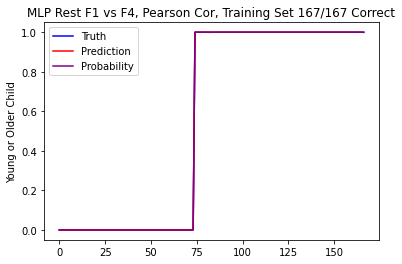

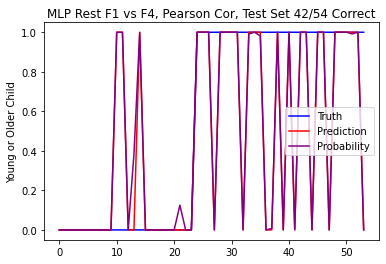

In [80]:
# Display results of Rest MLP

import matplotlib.pyplot as plt

def show_results(y_true, y_predict, y_prob=None, title="", label="Young or Older Child"):
    nCorrect = 0
    for i in range(len(y_true)):
        if y_true[i] == y_predict[i]:
            nCorrect += 1

    fig, ax = plt.subplots()
    
    ax.plot(y_true, color='blue', label='Truth')
    ax.plot(y_predict, color='red', label='Prediction')
    
    if y_prob is not None:
        ax.plot(y_prob, color='purple', label='Probability')
        
    ax.set_title(title + ' {:d}/{:d} Correct'.format(nCorrect, len(y_true)))
    ax.set_ylabel(label)
    ax.legend()

    plt.show()
    
def getResults(mlp, subjects):
    y_predict = []
    y_prob = []
    for subj in subjects:
        label = mlp(subj)
        idx = np.argmax(label.detach().numpy())
        loss = -label[idx] + torch.log(torch.sum(torch.exp(label)))
        loss = loss.detach().numpy()
        y_predict.append(idx)
        if idx == 0:
            y_prob.append(1-np.exp(-loss))
        else:
            y_prob.append(np.exp(-loss))
    return y_predict, y_prob
        
# Display Results

y1, y1p = getResults(mlpRest, F1F4_train_rest_cor_torch)
y2, y2p = getResults(mlpRest, F1F4_test_rest_cor_torch)

show_results(y_F1F4_train_rest, y1, y1p, "MLP Rest F1 vs F4, Pearson Cor, Training Set")
show_results(y_F1F4_test_rest, y2, y2p, "MLP Rest F1 vs F4, Pearson Cor, Test Set")

In [129]:
mlpNBack = MLPSingle()
optimNBack = torch.optim.SGD(mlpNBack.parameters(), momentum=0.5, lr=0.000002)

print('NBack complete')

NBack complete


In [134]:
N = len(F1F4_train_nback_cor_torch)-1

running = 0

for epoch in range(1000):
    # Choose subject
    idx = random.randint(0,N)
    subj = F1F4_train_nback_cor_torch[idx]
    truth = round(y_F1F4_train_rest[idx])
    
    # Train
    optimNBack.zero_grad()
    label = mlpNBack(subj)
    loss = -label[truth] + torch.log(torch.sum(torch.exp(label)))
    loss.backward()
    
    # Backpropagate
    optimNBack.step()
    
    running += loss.detach()

    # print statistics
    if epoch % 50 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, running/50))
        running = 0

print('Finished Training')

[epoch 0] loss: 0.000
[epoch 50] loss: 0.020
[epoch 100] loss: 0.008
[epoch 150] loss: 0.010
[epoch 200] loss: 0.015
[epoch 250] loss: 0.010
[epoch 300] loss: 0.006
[epoch 350] loss: 0.007
[epoch 400] loss: 0.010
[epoch 450] loss: 0.008
[epoch 500] loss: 0.005
[epoch 550] loss: 0.006
[epoch 600] loss: 0.008
[epoch 650] loss: 0.010
[epoch 700] loss: 0.014
[epoch 750] loss: 0.007
[epoch 800] loss: 0.005
[epoch 850] loss: 0.005
[epoch 900] loss: 0.006
[epoch 950] loss: 0.004
Finished Training


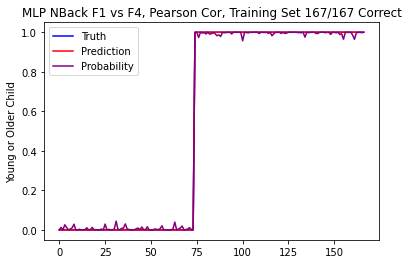

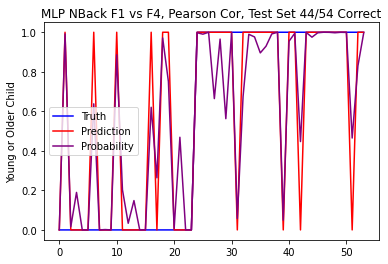

In [135]:
y1, y1p = getResults(mlpNBack, F1F4_train_nback_cor_torch)
y2, y2p = getResults(mlpNBack, F1F4_test_nback_cor_torch)

show_results(y_F1F4_train_rest, y1, y1p, "MLP NBack F1 vs F4, Pearson Cor, Training Set")
show_results(y_F1F4_test_rest, y2, y2p, "MLP NBack F1 vs F4, Pearson Cor, Test Set")

In [139]:
# Try the multi-task MLP

mlpMulti = MLPDouble()
optimMulti = torch.optim.SGD(mlpMulti.parameters(), momentum=0.5, lr=0.000001)

print('Multi complete')

Multi complete


In [143]:
N = len(F1F4_train_nback_cor_torch)-1

running = 0

for epoch in range(1000):
    # Choose subject
    idx = random.randint(0,N)
    subj1 = F1F4_train_rest_cor_torch[idx]
    subj2 = F1F4_train_nback_cor_torch[idx]
    truth = round(y_F1F4_train_rest[idx])
    
    # Train
    optimMulti.zero_grad()
    label = mlpMulti(torch.cat([subj1, subj2]))
    loss = -label[truth] + torch.log(torch.sum(torch.exp(label)))
    loss.backward()
    
    running += loss.detach()
    
    # Backpropagate
    optimMulti.step()

    # print statistics
    if epoch % 50 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, running/50))
        running = 0

print('Finished Training')

[epoch 0] loss: 0.000
[epoch 50] loss: 0.021
[epoch 100] loss: 0.031
[epoch 150] loss: 0.027
[epoch 200] loss: 0.022
[epoch 250] loss: 0.010
[epoch 300] loss: 0.029
[epoch 350] loss: 0.012
[epoch 400] loss: 0.013
[epoch 450] loss: 0.020
[epoch 500] loss: 0.010
[epoch 550] loss: 0.015
[epoch 600] loss: 0.016
[epoch 650] loss: 0.016
[epoch 700] loss: 0.012
[epoch 750] loss: 0.009
[epoch 800] loss: 0.010
[epoch 850] loss: 0.016
[epoch 900] loss: 0.011
[epoch 950] loss: 0.010
Finished Training


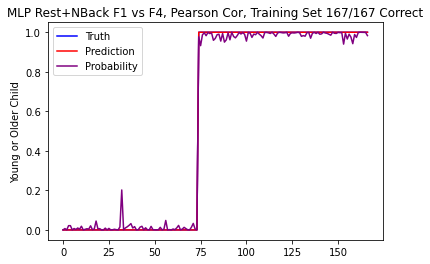

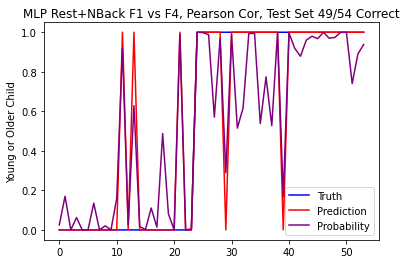

In [144]:
def getResultsMulti(mlp, subjects1, subjects2):
    y_predict = []
    y_prob = []
    for i in range(len(subjects1)):
        subj = torch.cat([subjects1[i], subjects2[i]])
        label = mlp(subj)
        idx = np.argmax(label.detach().numpy())
        loss = -label[idx] + torch.log(torch.sum(torch.exp(label)))
        loss = loss.detach().numpy()
        y_predict.append(idx)
        if idx == 0:
            y_prob.append(1-np.exp(-loss))
        else:
            y_prob.append(np.exp(-loss))
    return y_predict, y_prob

y1, y1p = getResultsMulti(mlpMulti, F1F4_train_rest_cor_torch, F1F4_train_nback_cor_torch)
y2, y2p = getResultsMulti(mlpMulti, F1F4_test_rest_cor_torch, F1F4_test_nback_cor_torch)

show_results(y_F1F4_train_rest, y1, y1p, "MLP Rest+NBack F1 vs F4, Pearson Cor, Training Set")
show_results(y_F1F4_test_rest, y2, y2p, "MLP Rest+NBack F1 vs F4, Pearson Cor, Test Set")

In [147]:
# Check best result against logistic regression

from sklearn.linear_model import LogisticRegression

X_F1F4_train_rest_nback_cor = np.zeros([len(F1F4_train_rest), 264*264*2])
X_F1F4_test_rest_nback_cor = np.zeros([len(F1F4_test_rest), 264*264*2])

for i in range(len(F1F4_train_rest)):
    X_F1F4_train_rest_nback_cor[i,:] = np.hstack([F1F4_train_rest_cor[i].flatten(), F1F4_train_nback_cor[i].flatten()])
    
for i in range(len(F1F4_test_rest)):
    X_F1F4_test_rest_nback_cor[i,:] = np.hstack([F1F4_test_rest_cor[i].flatten(), F1F4_test_nback_cor[i].flatten()])
    
print('Complete')

Complete


In [148]:
clf = LogisticRegression(max_iter=500).fit(X_F1F4_train_rest_nback_cor, y_F1F4_train_rest)
print('Finished')

Finished


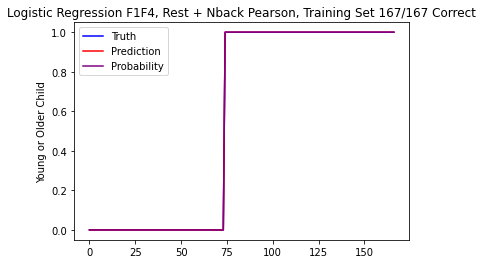

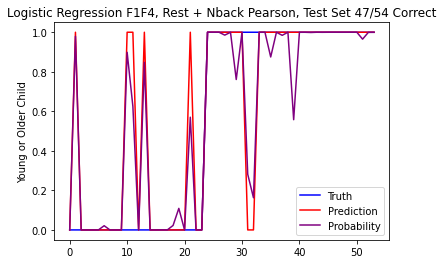

In [149]:
# Display results

def show_results(y_true, y_predict, y_prob=None, title="", label="Young or Older Child"):
    nCorrect = 0
    for i in range(len(y_true)):
        if y_true[i] == y_predict[i]:
            nCorrect += 1

    fig, ax = plt.subplots()
    
    ax.plot(y_true, color='blue', label='Truth')
    ax.plot(y_predict, color='red', label='Prediction')
    
    if y_prob is not None:
        ax.plot(y_prob[:,1], color='purple', label='Probability')
        
    ax.set_title(title + ' {:d}/{:d} Correct'.format(nCorrect, len(y_true)))
    ax.set_ylabel(label)
    ax.legend()

    plt.show()
    
y1 = clf.predict(X_F1F4_train_rest_nback_cor)
y1_prob = clf.predict_proba(X_F1F4_train_rest_nback_cor)
y1_test = clf.predict(X_F1F4_test_rest_nback_cor)
y1_test_prob = clf.predict_proba(X_F1F4_test_rest_nback_cor)

show_results(y_F1F4_train_rest, y1, y1_prob, 'Logistic Regression F1F4, Rest + Nback Pearson, Training Set')
show_results(y_F1F4_test_rest, y1_test, y1_test_prob, 'Logistic Regression F1F4, Rest + Nback Pearson, Test Set')